# PROJECT - Answering Business Questions Using SQL

### Introduction-
In this project, we're going to use SQL skills to answer business questions. We'll be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop.

### Aim          - 
To answer business questions using SQL skills Such as selecting albums to purchase, analyzing employee sales performance, and comparing album vs individual tracks.

### Database - 
The database used is the Chinook database, included in the files.The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. 

### 1-Introduction and Schema Diagram

### Chinook Database Schema -
This information is contained in eleven tables. A schema diagram will help us understand the available columns and the structure of the data. A schema diagram is also uploaded here for the Chinook database.

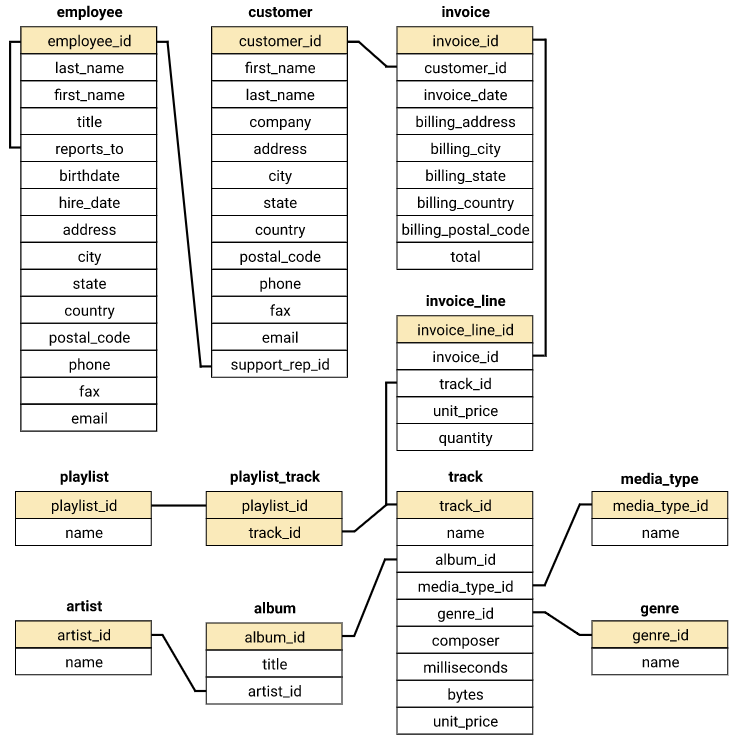

### 2- Import Libraries

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

### 3- Defining Functions

In [2]:
db = r'C:\Users\anuja\Downloads\chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT 
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table','view');
    '''
    return run_query(q)

In the above step, we've defined:

* **'run_query()'    function** - takes a SQL query as an argument and returns a pandas dataframe of that query.
* **'run_command()'  function** - takes a SQL command as an argument and executes it using the sqlite module.
* **'show_tables()'  function** - calls the 'run_query()' function to return a list of all tables and views in the database.

### 4- Overview of the Data

**To query the database to get a list of tables and views in our database**

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### 5- Selecting Albums to Purchase

**Question 1 - Selecting Albums to Purchase**

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name	|Genre|
|---------------|-----|
|Regal	|Hip-Hop|
|Red Tone	|Punk|
|Meteor and the Girls	|Pop|
|Slim Jim Bites	|Blues|

**Method -**
Write a query that returns each genre, with the number of tracks sold in the USA:
* in absolute numbers
* in percentages.

In [5]:
# to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

albums_to_purchase = '''
WITH usa_tracks_sold AS
     (
      SELECT il.*
      FROM invoice_line il
      INNER JOIN invoice i ON i.invoice_id = il.invoice_id
      INNER JOIN customer c on c.customer_id = i.customer_id
      WHERE c.country = 'USA'
     )
      
SELECT 
      g.name genre_name,
      COUNT(uts.invoice_line_id) number_of_tracks_sold,
      CAST(COUNT(uts.invoice_line_id) AS FLOAT)/(
           SELECT COUNT(*) FROM usa_tracks_sold
      ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre_name,number_of_tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


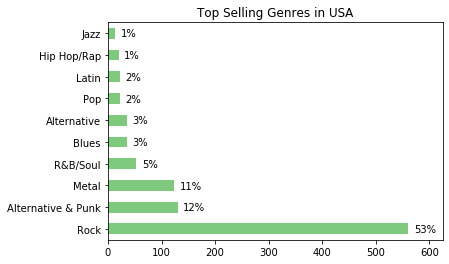

In [6]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('genre_name', drop = True, inplace = True)

genre_sales_usa['number_of_tracks_sold'].plot.barh(
     title = 'Top Selling Genres in USA',
     xlim = (0, 625),
     colormap = plt.cm.Accent
    )
plt.ylabel('')

for i,label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label,'number_of_tracks_sold']
    label = (genre_sales_usa.loc[label, 'percentage_sold'] * 100).astype(int).astype(str) + '%'
    plt.annotate(str(label),(score + 10, i - 0.15))

plt.show()

In [7]:
albums_to_purchase = '''
WITH track_sold_in_usa AS
    (
    SELECT il.invoice_line_id, il.track_id, i.invoice_id, i.billing_country
    FROM invoice i
    INNER JOIN invoice_line il ON i.invoice_id == il.invoice_id
    WHERE billing_country == "USA"
    )

SELECT g.name genre,
       a.title album,
       ar.name artist,
       COUNT(tsiu.invoice_line_id) "tracks sold",
       tsiu.billing_country
FROM track_sold_in_usa tsiu
INNER JOIN track t ON tsiu.track_id == t.track_id
INNER JOIN genre g ON g.genre_id == t.genre_id
INNER JOIN album a ON a.album_id == t.album_id
INNER JOIN artist ar ON a.artist_id == ar.artist_id
WHERE g.name IN ("Rock", "Alternative & Punk", "Metal")
GROUP BY a.title
ORDER BY COUNT(tsiu.invoice_line_id) DESC
'''
run_query(albums_to_purchase)

,genre,album,artist,tracks sold,billing_country
0,Rock,From The Muddy Banks Of The Wishkah [live],Nirvana,28,USA
1,Rock,Are You Experienced?,Jimi Hendrix,28,USA
2,Rock,The Doors,The Doors,27,USA
3,Rock,"Hot Rocks, 1964-1971 (Disc 1)",The Rolling Stones,25,USA
4,Alternative & Punk,Green,R.E.M.,25,USA
...,...,...,...,...,...
119,Rock,BBC Sessions [Disc 1] [live],Led Zeppelin,1,USA
120,Rock,B-Sides 1980-1990,U2,1,USA
121,Metal,Alcohol Fueled Brewtality Live! [Disc 1],Black Label Society,1,USA
122,Rock,A Matter of Life and Death,Iron Maiden,1,USA


**Answer 1-**
I would recommend following best seller artists - albums  in USA to purchase - 

* Nirvana (Rock)
* Jimi Hendrix (Rock)
* The Doors	(Rock)
* The Rolling Stones(Rock)
* R.E.M. (Alternative & Punk)

And from the given list of four, following album can be purchased -
* Red Tone (Punk)

It's worth keeping in mind that 'rock' genre accounts for 53% of sales whereas Punk accounts for 12% and Metal accounts for 11%. I recommend to go for 'rock' genre.

### 6- Analyzing Employee Sales Performance


**Question 2 - Analyzing Employee Sales Performance**

Analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [8]:
q1 = '''
SELECT * FROM employee
LIMIT 2;'''
employee = run_query(q1)
employee

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com


In [9]:
q2 = '''
SELECT * FROM customer
LIMIT 2;'''
customer = run_query(q2)
customer

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5


In [10]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT 
          c.customer_id,
          c.support_rep_id, 
          SUM(i.total) total
     FROM customer c 
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT 
     e.first_name || " " || e.last_name employee_name,
     e.hire_date,
     SUM(csrs.total) total_sales
FROM employee e
INNER JOIN customer_support_rep_sales csrs ON csrs.support_rep_id = e.employee_id
WHERE e.title = 'Sales Support Agent'
GROUP BY 1
ORDER BY 3 DESC;
'''

run_query(employee_sales_performance)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


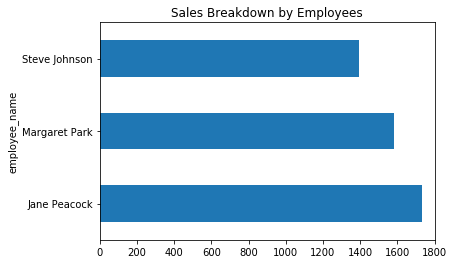

In [11]:
employee_contribution = run_query(employee_sales_performance)
employee_contribution.plot.barh(x="employee_name", y="total_sales", title="Sales Breakdown by Employees", legend=False, xlim=(0,1800))

**Answer 2** - Jane Peacock	(the top employee)has highest sale and hiring is done in April, Margaret Park	hired in May followed by Steve Johnson(the bottom employee) hired in October month.

So employees hired earlier have more succesful sales records than the newer ones.

### 7- Analyzing Sales by Country


**Question 3 - Analyzing Sales by Country**

Analyse sales for each country, include:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

where **Others** column include countries with only one customer.

In [12]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        COUNT(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(DISTINCT(customer_id)) customer_lifetime_value,
        SUM(unit_price) / COUNT(DISTINCT(invoice_id)) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


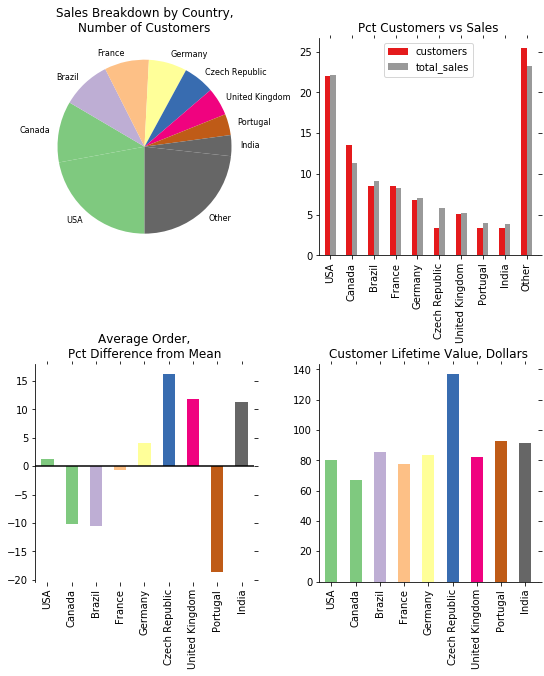

In [13]:
# Visualising Sales by Country
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

**Answer 3 -**Based on the data, there may be opportunity in the following countries:

* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

### 8- Albums vs Individual Tracks

**Question 4-**Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
* Number of invoices
* Percentage of invoices

In [14]:
album_vs_individual_purchases = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;'''
run_query(album_vs_individual_purchases)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


**Answer 4- Albums vs Individual Tracks** Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

**Questions -**
* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?

**Questions 5 -** Which artist is used in the most playlists?

In [15]:
popular_artist = 'WITH \
        track_artist AS \
                      (SELECT t.track_id, al_ar.artist_name \
                      FROM track t LEFT JOIN \
                      (SELECT a.name artist_name, \
                      al.album_id FROM album al LEFT JOIN \
                      artist a ON a.artist_id=al.artist_id) \
                      al_ar ON al_ar.album_id=t.album_id \
                      ORDER BY(2)), \
        playlist_name_track AS \
                      (SELECT p.name playlist_name, pt.track_id \
                      FROM playlist_track pt \
                      LEFT JOIN playlist p \
                      ON p.playlist_id=pt.playlist_id \
                      ORDER BY(1)) \
SELECT t_a.artist_name, COUNT(pnt.playlist_name) \
                       FROM playlist_name_track pnt \
                       LEFT JOIN track_artist t_a \
                       ON t_a.track_id = pnt.track_id \
                       GROUP BY(1) ORDER BY(2) DESC;'

run_query(popular_artist).head(5)

,artist_name,COUNT(pnt.playlist_name)
0,Iron Maiden,516
1,U2,333
2,Metallica,296
3,Led Zeppelin,252
4,Deep Purple,226


**Answer 5-**Iron Maiden is most popular artist.

**Question 6-** How many tracks have been purchased vs not purchased?

In [16]:
run_query('WITH tt AS \
          (SELECT COUNT(DISTINCT(track_id)) tracks_purchased, \
(SELECT COUNT(*) FROM track) total_tracks \
FROM invoice_track ORDER BY(1)) \
SELECT tracks_purchased, (total_tracks-tracks_purchased) tracks_not_purchased \
FROM tt;')


,tracks_purchased,tracks_not_purchased
0,1806,1697


**Answer 6-** There are 1806 tracks purchased and 1697 not purchased.


**Question 7-** Is the range of tracks in the store reflective of their sales popularity?

In [17]:
run_query('SELECT COUNT(*) range_tracks, \
(SELECT COUNT(*) FROM invoice_track) total_tracks_sold, \
(SELECT COUNT(DISTINCT(track_id)) FROM invoice_track) distinct_tracks_sold \
FROM track')

,range_tracks,total_tracks_sold,distinct_tracks_sold
0,3503,4757,1806


**Answer 7-** Almost the 51% of the range of tracks in the store have been sold

**Question 8-** Most Popular Media Type?

In [18]:
result= run_query('SELECT m.name Media_Type, \
                  m.media_type_id, COUNT(it.invoice_line_id) total_sales\
                  FROM media_type m \
                  INNER JOIN (SELECT t.track_id, t.media_type_id, il.invoice_line_id \
                  FROM track t INNER JOIN invoice_line il \
                  ON il.track_id = t.track_id) it \
                  ON it.media_type_id = m.media_type_id \
                  GROUP BY(Media_Type) ORDER BY(3) DESC')

result

,Media_Type,media_type_id,total_sales
0,MPEG audio file,1,4259
1,Protected AAC audio file,2,439
2,Purchased AAC audio file,4,35
3,AAC audio file,5,21
4,Protected MPEG-4 video file,3,3


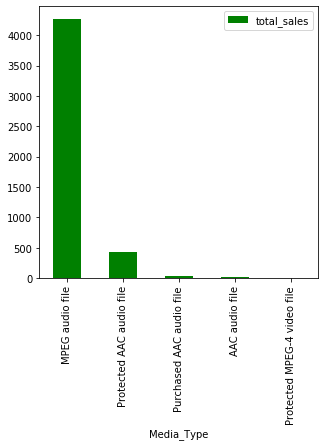

In [19]:
result.plot(x='Media_Type',y='total_sales', color='g',figsize=(5,5), kind='bar')

**Answer 8 -** MPEG is the most popular media type

This project which aims to answer business questions using SQLSkills is completed.